In [ ]:
import warnings
warnings.filterwarnings('ignore')

### Unzip the dataset

In [ ]:
!unzip brain_tumor_dataset.zip

Archive:  brain_tumor_dataset.zip
  inflating: Br35H-Mask-RCNN/TEST/annotations_test.json  
  inflating: Br35H-Mask-RCNN/TEST/y701.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y702.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y703.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y704.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y705.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y706.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y707.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y708.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y709.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y710.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y711.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y712.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y713.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y714.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y715.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y716.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y717.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y718.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y719.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y720.jpg  
  inflat

### Importing Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import shutil
import glob

In [ ]:
ROOT_DIR = '/content/dataset'
number_of_img = {}

for dir in os.listdir(ROOT_DIR):
    number_of_img[dir] = len(os.listdir(os.path.join(ROOT_DIR, dir)))

In [ ]:
number_of_img.items()

dict_items([('no', 1500), ('yes', 1500)])

### We split the dataset into
* 70% for training data
* 15% for validation data
* 15% for test data

In [ ]:
def dataFolder(p, split):
    if not os.path.exists('./' + p):
        os.mkdir('./' + p)

        for dir in os.listdir(ROOT_DIR):
            os.makedirs('./' + p + '/' + dir)

            for img in np.random.choice(a = os.listdir(os.path.join(ROOT_DIR, dir)), 
                                            size=(math.floor(split*number_of_img[dir]) - 2), 
                                            replace=False):
                O = os.path.join(ROOT_DIR, dir, img)
                D = os.path.join('./' + p, dir)
                shutil.copy(O, D)
                os.remove(O)

    else:
        print(f"{p} Folder Exists")

In [ ]:
dataFolder('TRAIN', 0.7)

In [ ]:
dataFolder('VAL', 0.15)

In [ ]:
dataFolder('TEST', 0.15)

### Build Model

In [ ]:
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAvgPool2D
from keras.models import Sequential
from keras_preprocessing.image import ImageDataGenerator
import keras

In [ ]:
# CNN Model
model = Sequential()

model.add(Conv2D(filters= 16, kernel_size= (3, 3), activation= 'relu', input_shape= (224, 224, 3)))

model.add(Conv2D(filters=36, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Dropout(rate=0.15))

model.add(Flatten())
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(rate=0.15))
model.add(Dense(units=1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 36)      5220      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 36)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 64)      20800     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 52, 52, 128)       7

In [ ]:
model.compile(optimizer='adam', loss= keras.losses.binary_crossentropy, metrics=['accuracy'])

### Preparing our data with Data Generator

In [ ]:
def preprocessingImages(path):
  image_data = ImageDataGenerator(zoom_range=0.2, shear_range=0.2, rescale=1/255, horizontal_flip=True)
  image = image_data.flow_from_directory(directory=path, target_size=(224, 224), batch_size=32, class_mode='binary')

  return image

In [ ]:
path = '/content/TRAIN'
train_data = preprocessingImages(path)

Found 2096 images belonging to 2 classes.


In [ ]:
def preprocessingImages2(path):
  image_data = ImageDataGenerator(rescale=1/255)
  image = image_data.flow_from_directory(directory=path, target_size=(224, 224), batch_size=32, class_mode='binary')

  return image

In [ ]:
path = '/content/VAL'
val_data = preprocessingImages2(path)

Found 446 images belonging to 2 classes.


In [ ]:
path = '/content/TEST'
test_data = preprocessingImages2(path)

Found 446 images belonging to 2 classes.


In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

es = EarlyStopping(monitor='accuracy', min_delta=0.01, patience=5, verbose = 1, mode = 'auto')

mc = ModelCheckpoint(monitor='accuracy', filepath='./bestmodel.h5', verbose = 1, save_best_only=True, mode='auto')

cd = [es, mc]

### Model Training

In [ ]:
hs = model.fit_generator(generator = train_data, 
                         steps_per_epoch=8, 
                         epochs=30, verbose = 1, 
                         validation_data = val_data, 
                         validation_steps = 16, callbacks = cd)

Epoch 1/30
8/8 [==============================] - ETA: 0s - loss: 0.3753 - accuracy: 0.8594


Epoch 1: accuracy did not improve from 0.86719
8/8 [==============================] - 5s 609ms/step - loss: 0.3753 - accuracy: 0.8594 - val_loss: 0.3615 - val_accuracy: 0.8655
Epoch 2/30
8/8 [==============================] - ETA: 0s - loss: 0.3462 - accuracy: 0.8516
Epoch 2: accuracy did not improve from 0.86719
8/8 [==============================] - 3s 364ms/step - loss: 0.3462 - accuracy: 0.8516
Epoch 3/30
8/8 [==============================] - ETA: 0s - loss: 0.3452 - accuracy: 0.8516
Epoch 3: accuracy did not improve from 0.86719
8/8 [==============================] - 3s 374ms/step - loss: 0.3452 - accuracy: 0.8516
Epoch 4/30
8/8 [==============================] - ETA: 0s - loss: 0.4121 - accuracy: 0.8125
Epoch 4: accuracy did not improve from 0.86719
8/8 [==============================] - 3s 370ms/step - loss: 0.4121 - accuracy: 0.8125
Epoch 5/30
8/8 [==============================] - ETA: 0s - loss: 0.3607 - accuracy: 0.8516
Epoch 5: accuracy did not improve from 0.86719
8/8 [=

In [ ]:
# Model Graphical Interpretation
h = hs.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

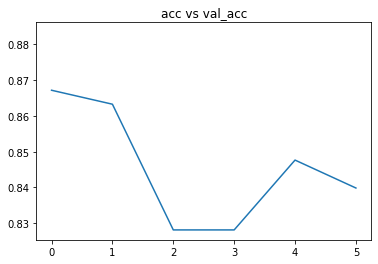

In [ ]:
import matplotlib.pyplot as plt

plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'], c = 'red')

plt.title('acc vs val_acc')
plt.show()

In [ ]:
# Model Accuracy
from keras.models import load_model

model = load_model('/content/bestmodel.h5')

### Model Accuracy

In [ ]:
acc = model.evaluate_generator(test_data)[1]

print(f'The accuracy of the model is {acc}')

The accuracy of the model is 0.8587443828582764


In [ ]:
from keras_preprocessing.image import load_img, img_to_array

In [ ]:
path = "/content/pred/pred54.jpg"

img = load_img(path, target_size=(224, 224))
input_arr = img_to_array(img)/255

input_arr = np.expand_dims(input_arr, axis = 0)

pred = model.predict(input_arr)[0][0]
pred

0.9341649

In [ ]:
train_data.class_indices

{'no': 0, 'yes': 1}

In [ ]:
if pred >= 0.5:
  print('Is a Brain Tumor')
else:
  print('NOT a Brain Tumor')

Is a Brain Tumor
